In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


[*********************100%***********************]  1 of 1 completed


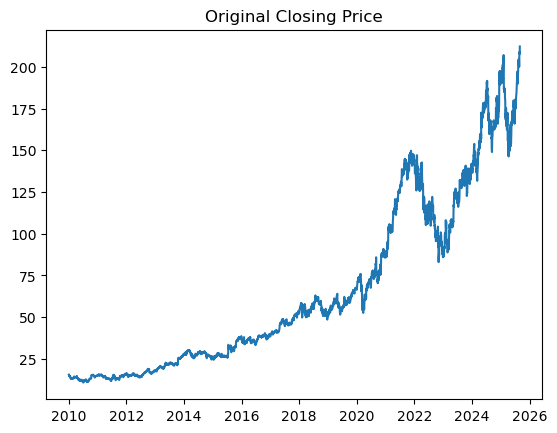

In [19]:
ticker = "GOOG"
df = yf.download(ticker, start="2010-01-01", end="2025-08-29")[["Close"]]
df.rename(columns={"Close":"close"}, inplace=True)
df.dropna(inplace=True)

plt.plot(df['close'])
plt.title("Original Closing Price")
plt.show()


In [20]:
result = adfuller(df["close"])
pvalue = result[1]
print("ADF p-value:", pvalue)
original_prices = df["close"].values  # original stock prices

ADF p-value: 0.9951337083127685


In [ ]:
random_noise = df['close'].diff().dropna()

mean_noise = random_noise.mean()
mean_noise

Ticker
GOOG    0.049956
dtype: float64

In [4]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['close']])

In [5]:
def create_dataset(data, time_step=50):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 50
X, y = create_dataset(scaled, time_step)

In [43]:
combined_array_concat

array([[0.02342146, 0.02308244, 0.02115031, ..., 0.01561308, 0.0158612 ,
        0.01590541],
       [0.02308244, 0.02115031, 0.01941101, ..., 0.0158612 , 0.01590541,
        0.01600859],
       [0.02115031, 0.01941101, 0.02038384, ..., 0.01590541, 0.01600859,
        0.01522248],
       ...,
       [0.81897397, 0.82919354, 0.82567125, ..., 0.97197053, 0.98407531,
        0.97807251],
       [0.82919354, 0.82567125, 0.80954805, ..., 0.98407531, 0.97807251,
        0.97936243],
       [0.82567125, 0.80954805, 0.77854195, ..., 0.97807251, 0.97936243,
        1.        ]])

In [28]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]

test_start_idx = train_size + time_step

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred_scaled = lr.predict(X_test)

In [8]:
lr_pred = scaler.inverse_transform(lr_pred_scaled.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

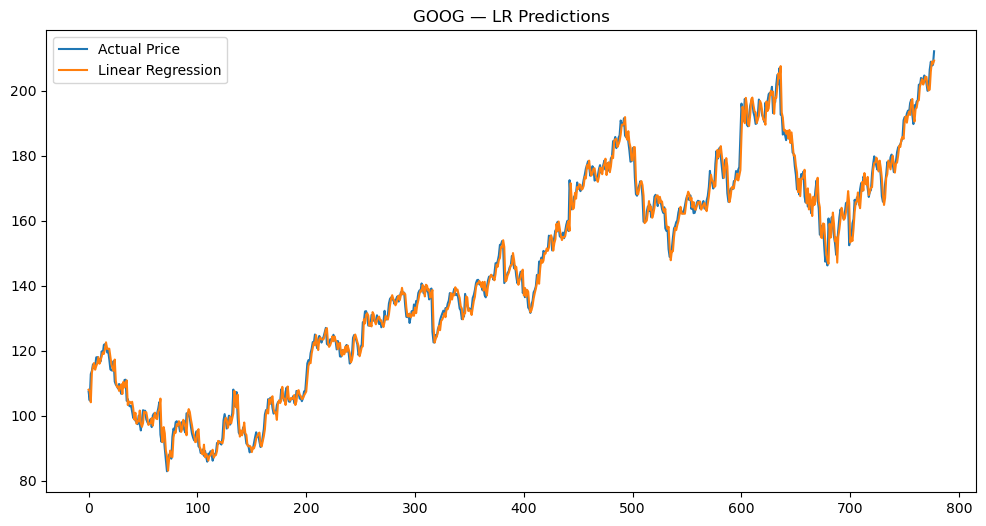

In [9]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(lr_pred, label="Linear Regression")
plt.legend()
plt.title("GOOG — LR Predictions")
plt.show()

In [10]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

ridge_pred_scaled = ridge.predict(X_test)
ridge_pred = scaler.inverse_transform(ridge_pred_scaled.reshape(-1,1))

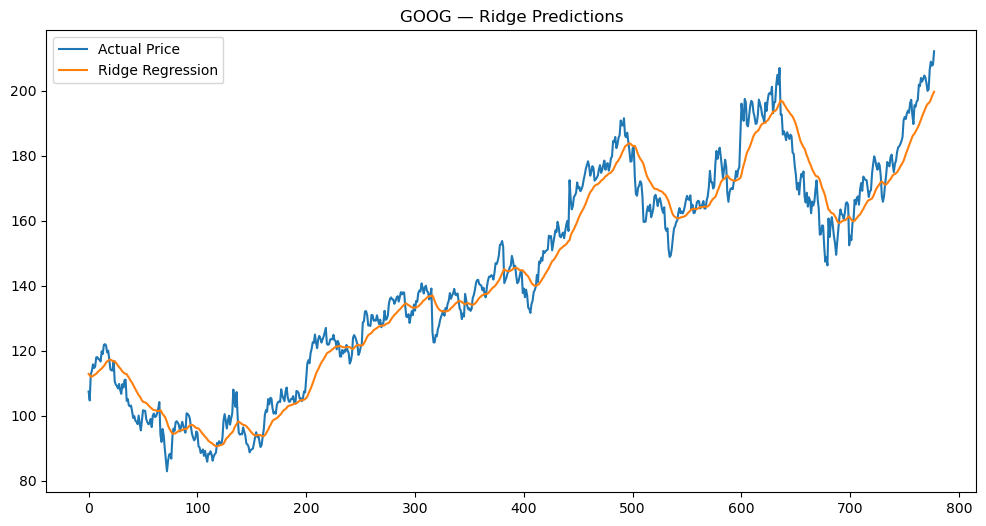

In [11]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(ridge_pred, label="Ridge Regression")
plt.legend()
plt.title("GOOG — Ridge Predictions")
plt.show()

In [12]:
X_train_lstm = X_train.reshape(X_train.shape[0], time_step, 1)
X_test_lstm  = X_test.reshape(X_test.shape[0], time_step, 1)

In [13]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(time_step,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")

model.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
          validation_data=(X_test_lstm, y_test),
          verbose=1)

Epoch 1/20


c:\Users\dpiso\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6619e-04 - val_loss: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8154e-04 - val_loss: 7.7567e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.9286e-04 - val_loss: 0.0018
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.8420e-04 - val_loss: 0.0015
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.7124e-04 - val_loss: 0.0011
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.4150e-04 - val_loss: 0.0018
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3554e-04 - val_loss: 6.0160e-04
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3920e-04 - val_loss: 6.7376e-04
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1408e-04 - val_loss: 0.0012
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0805e-04 - val_loss: 6.8708e-04
Epoch 12/20
98/98 

In [14]:
lstm_pred = model.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_pred))

print("LSTM RMSE:", rmse_lstm)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM RMSE: 0.029922857864816067


In [15]:
lstm_pred_scaled = model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


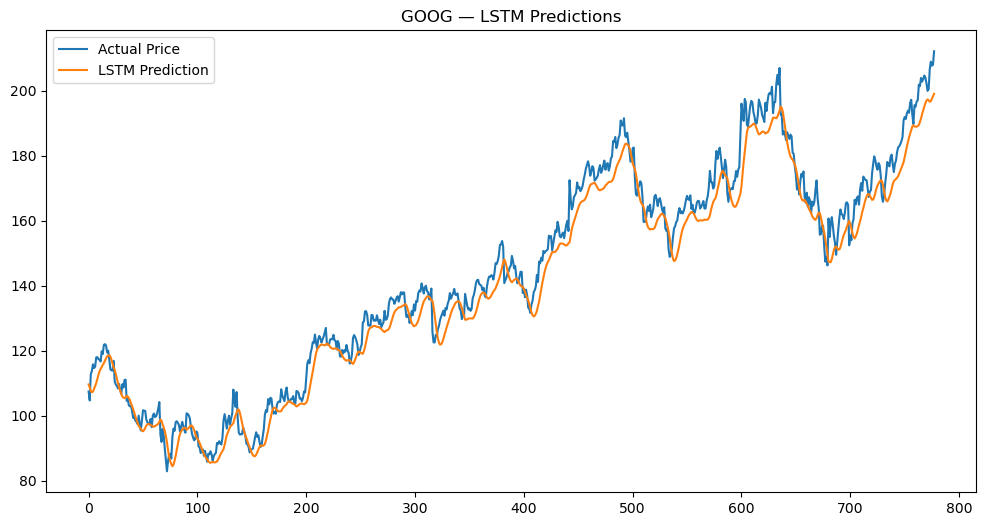

In [16]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(lstm_pred, label="LSTM Prediction")
plt.legend()
plt.title("GOOG — LSTM Predictions")
plt.show()

In [ ]:
rw_pred_price = np.zeros_like(original_prices)

rw_pred_price[0] = original_prices[0]

for t in range(1, len(original_prices)):
    rw_pred_price[t] = original_prices[t-1] + mean_noise

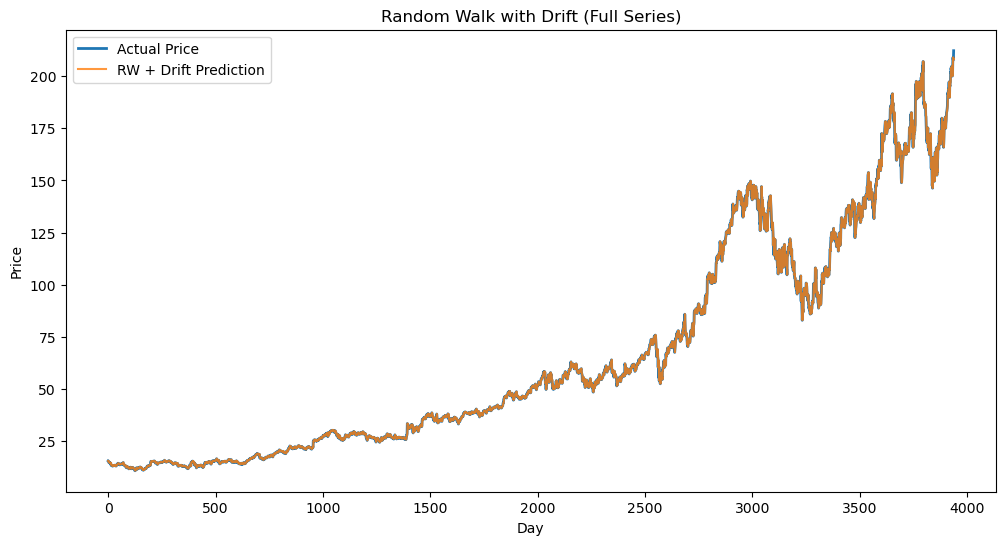

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(original_prices, label="Actual Price", linewidth=2)
plt.plot(rw_pred_price, label="RW + Drift Prediction", alpha=0.8)
plt.title("Random Walk with Drift (Full Series)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

In [34]:
new_rw_pred_price = np.zeros_like(original_prices)

new_rw_pred_price[0] = original_prices[0]

for t in range(1, (len(original_prices))//2):
    new_rw_pred_price[t] = original_prices[t-1] + mean_noise

for t in range((len(original_prices))//2, len(original_prices)):
    new_rw_pred_price[t] = new_rw_pred_price[t-1] + mean_noise

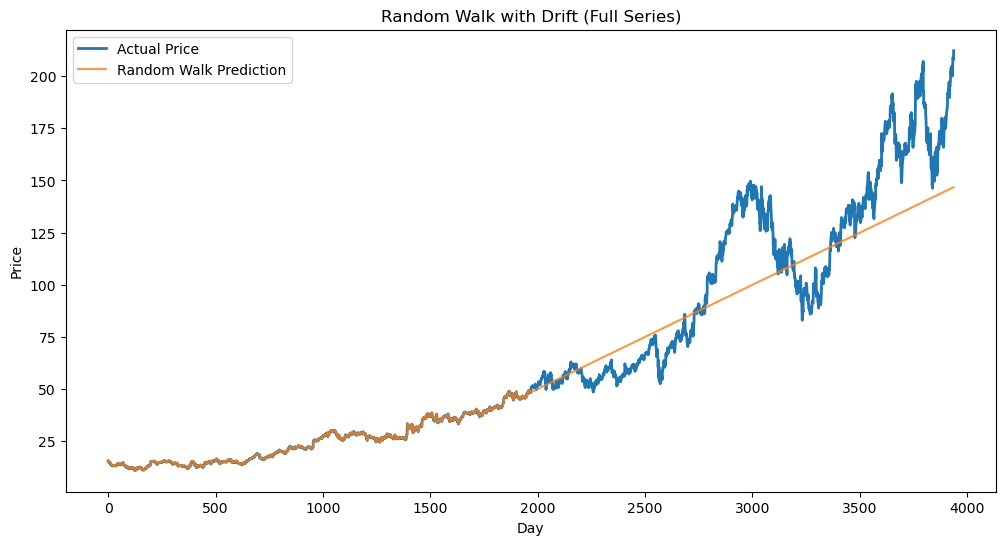

In [35]:
plt.figure(figsize=(12,6))
plt.plot(original_prices, label="Actual Price", linewidth=2)
plt.plot(new_rw_pred_price, label="Random Walk Prediction", alpha=0.8)
plt.title("Random Walk with Drift (Full Series)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()